<a href="https://colab.research.google.com/github/luckyswaminathan/MusicVibe/blob/main/gloVeNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## imports
## gloVe credits:
## Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]
## am adapting structure given by https://www.youtube.com/watch?v=e0WW5w13V64&t=68s&ab_channel=GregHogg to create
## an NLP model for my app Music Vibe (data source requires no credits as is open source)
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
url = 'https://raw.githubusercontent.com/luckyswaminathan/MusicVibe/main/tweet_emotions.csv'

msc_df = pd.read_csv(url)


sentiment_mapping = dict.fromkeys(["anger", "hate", "sadness", "worry"], (np.array([1,0,0])))

sentiment_mapping.update(dict.fromkeys(["boredom", "empty", "neutral"], (np.array([0,1,0]))))

sentiment_mapping.update(dict.fromkeys(["enthusiasm", "fun", "happiness", "love", "relief", "surprise"], (np.array([0,0,1]))))

msc_df['sentiment'] = msc_df['sentiment'].map(sentiment_mapping)

# Map the sentiment values using the mapping dictionary


# Check the value counts
msc_df['sentiment'].value_counts()



[0, 0, 1]    15299
[1, 0, 0]    15057
[0, 1, 0]     9644
Name: sentiment, dtype: int64

In [3]:
## using gloVE rather than word2vec because works better with small dataset

!wget http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip

--2023-06-13 19:34:44--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.33MB/s    in 4m 47s  

2023-06-13 19:39:31 (5.06 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [5]:
words = dict()
def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')
      d[line[0]] = np.array(line[1:], dtype=float)

add_to_dict(words, 'glove.twitter.27B.50d.txt')
len(words)

1193514

In [6]:
import nltk as nl
nl.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
tokenizer = nl.RegexpTokenizer(r"\w+")

## LEMMATIZATION -- concatenating variants of a word to one form

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


## tokenizes and lemmatizes all words that are in gloVe word set
def tokenLem(s):
  tokens = tokenizer.tokenize(s)
  tokens = [word.lower() for word in tokens]
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  tokens = [word for word in tokens if word in words]

  return tokens


In [8]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = tokenLem(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)



In [9]:
## train_test_split



train_df, mix_df = train_test_split(msc_df, random_state=42, test_size = 0.3)

val_df, test_df = train_test_split(mix_df, random_state=42, test_size = 0.5)


len(train_df), len(val_df), len(test_df)


(28000, 6000, 6000)

In [10]:
## splitting train,val, test into sentiment and content


def df_to_SC(dff):
  ## sentiment for sentence
  y = dff['sentiment'].to_numpy()

  ## content array
  all_word_vector_sequences = []

  for message in dff['content']:
    message_as_vector_seq = message_to_word_vectors(message)

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y




In [11]:
word_train, feel_train = df_to_SC(train_df)



len(word_train[0])

26

(array([3180., 4294., 5883., 3589., 4014., 2663., 2932., 1152.,  282.,
          11.]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

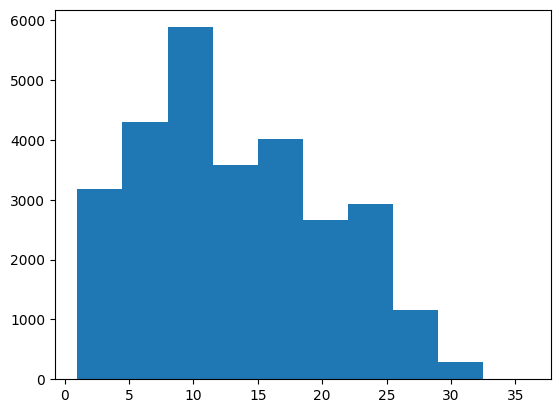

In [12]:
sequence_lengths = []

for i in range(len(word_train)):
  sequence_lengths.append(len(word_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [13]:
## making the df into a np array

from copy import deepcopy

def pad_X(X, desired_sequence_length=38):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [14]:
word_train = pad_X(word_train)
print(len(word_train[0]))


word_val, feel_val = df_to_SC(val_df)
word_val = pad_X(word_val)

word_test, feel_test = df_to_SC(test_df)
word_test = pad_X(word_test)




38


In [28]:
## LSTM model

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras

model = Sequential()

model.add(layers.Input(shape=(38, 50)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.2))
l1_regularization = keras.regularizers.l1(0.05)  #
model.add(keras.layers.Dense(units=64, activation='relu', kernel_regularizer=l1_regularization))
model.add(layers.LSTM(64, return_sequences=True))
l2_regularization = keras.regularizers.l2(0.05)
model.add(keras.layers.Dense(units=64, activation = 'relu', kernel_regularizer=l2_regularization))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))


In [29]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [ ]:
print(feel_train)

[array([1, 0, 0]) array([0, 1, 0]) array([0, 1, 0]) ... array([0, 0, 1])
 array([1, 0, 0]) array([0, 0, 1])]


In [30]:
frequencies = pd.value_counts(train_df['sentiment'])
print(frequencies)
## weighting loss function as datset imbalanced

weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1], 2: frequencies.sum() / frequencies[2]}
weights

[0, 0, 1]    10695
[1, 0, 0]    10580
[0, 1, 0]     6725
Name: sentiment, dtype: int64


{0: 2.6180458158017763, 1: 2.6465028355387523, 2: 4.163568773234201}

In [31]:
word_train = word_train.astype(np.float32)
word_val = word_val.astype(np.float32)




# Convert elements of feel_train to float32 type
feel_train = np.array([np.array(arr, dtype=np.float32) for arr in feel_train])
feel_val = np.array([np.array(arr, dtype=np.float32) for arr in feel_val])


In [32]:


model.fit(tf.convert_to_tensor(word_train), tf.convert_to_tensor(feel_train), validation_data=(tf.convert_to_tensor(word_val), tf.convert_to_tensor(feel_val)), epochs=40, callbacks=[cp], class_weight=weights)


Epoch 1/40
875/875 [==============================] - ETA: 0s - loss: 5.9204 - accuracy: 0.5102 - auc: 0.6925

875/875 [==============================] - 153s 167ms/step - loss: 5.9204 - accuracy: 0.5102 - auc: 0.6925 - val_loss: 1.0912 - val_accuracy: 0.5375 - val_auc: 0.7198
Epoch 2/40
875/875 [==============================] - ETA: 0s - loss: 2.9596 - accuracy: 0.5573 - auc: 0.7370

875/875 [==============================] - 141s 161ms/step - loss: 2.9596 - accuracy: 0.5573 - auc: 0.7370 - val_loss: 1.0171 - val_accuracy: 0.5892 - val_auc: 0.7643
Epoch 3/40
875/875 [==============================] - 117s 133ms/step - loss: 2.8844 - accuracy: 0.5778 - auc: 0.7528 - val_loss: 1.0174 - val_accuracy: 0.5867 - val_auc: 0.7574
Epoch 4/40
875/875 [==============================] - ETA: 0s - loss: 2.8195 - accuracy: 0.5935 - auc: 0.7664

875/875 [==============================] - 136s 156ms/step - loss: 2.8195 - accuracy: 0.5935 - auc: 0.7664 - val_loss: 0.9966 - val_accuracy: 0.6065 - val_auc: 0.7741
Epoch 5/40
875/875 [==============================] - ETA: 0s - loss: 2.7653 - accuracy: 0.6064 - auc: 0.7767

875/875 [==============================] - 140s 160ms/step - loss: 2.7653 - accuracy: 0.6064 - auc: 0.7767 - val_loss: 0.9832 - val_accuracy: 0.6032 - val_auc: 0.7780
Epoch 6/40
875/875 [==============================] - 117s 134ms/step - loss: 2.7251 - accuracy: 0.6143 - auc: 0.7838 - val_loss: 0.9890 - val_accuracy: 0.5997 - val_auc: 0.7715
Epoch 7/40
875/875 [==============================] - 116s 133ms/step - loss: 2.6749 - accuracy: 0.6260 - auc: 0.7935 - val_loss: 1.0052 - val_accuracy: 0.6043 - val_auc: 0.7748
Epoch 8/40
875/875 [==============================] - 114s 131ms/step - loss: 2.6278 - accuracy: 0.6388 - auc: 0.8023 - val_loss: 1.0014 - val_accuracy: 0.5935 - val_auc: 0.7699
Epoch 9/40
875/875 [==============================] - 115s 132ms/step - loss: 2.5722 - accuracy: 0.6462 - auc: 0.8119 - val_loss: 0.9957 - val_accuracy: 0.6003 - val_auc: 0.7744
Epoch 10/40
875/875 [==============================] - 116s 133ms/step - loss: 2.5117 - accuracy: 0.6619 - auc: 0.8219 - 

In [35]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

best_model.save("name.h5")

In [34]:

test_predictions = best_model.predict(word_test)
print(test_predictions)

# from sklearn.metrics import classification_report

# print(classification_report(feel_test, test_predictions))

188/188 [==============================] - 10s 43ms/step
[[0.09389442 0.27623433 0.62987125]
 [0.63987505 0.14460124 0.2155237 ]
 [0.15992957 0.10186044 0.73821   ]
 ...
 [0.4088222  0.24776395 0.3434138 ]
 [0.076953   0.10082828 0.8222188 ]
 [0.8702171  0.06342348 0.06635942]]
